## RKR Computation
All Code and Markdown written by Gary Zeri, Chapman University Student and member of the LaRue Cat Lab

All equations and information within this notebook originated from <i>The Computation of RKR Potential Energy Curves of Diatomic Molecules using Matematica</i>, written by Peter Senn.

The RKR method is a procedure used to determine the potential energy curves of diatomic molecules by calculating the classical turning points, $r_-$ and $r_+$ from the molecule's diatomic constants.


The turning points, $r_{\pm}$, can be computed using the following equation:
$$r_{\pm} = \frac{f(v)}{2} \cdot \left[\sqrt{1 + \frac{1}{f(v)g(v)}} \pm 1\right]$$
<br>
It should be noted that in the above equation the fraction in the square root has a one in the numerator while in the paper by Peter Senn the numerator has a four. The four is not present in the Matematica code in Senn's paper and in <i>Lecture #21: Construction of Potential Curves by the Rydberg-Klein-Rees Method (RKR)</i> from MIT OpenCourseWare, the four is not included as well, leading to the omission of the four in the equation presented here to provide an exact equation to that used within the below code.
<br><br>
$f(v)$ and $g(v)$ are defined as follows: 
$$f(v) = \int^v_{\frac{-1}{2}}{ \left[ \frac{dv^{'}}{\sqrt{E(v)-E(v^{'})}{}} \right] }$$
<br>
$$g(v) = \int_{\frac{-1}{2}}^v{\left[ \frac{\frac{\partial E}{\partial J}}{\sqrt{E(v) - E(v^{'})}}\right]dv^{'}}$$

<br>

In the original paper by Senn, there are constants in front of the integrals that are omitted here as they are used to scale the values to a desired unit system. Since this RKR code will use wavenumbers for energy and angstroms for bond distance, the constant of $\frac{8.211609}{\sqrt{\mu}}$ will be multiplied by the final answers to perform the conversion to Hartrees as an energy value.

<br>

For vibronic states with no rotation and $J=0$, $E(v)$ and $\frac{\partial E}{\partial J}$ can be represented as:
$$E(v) = \omega_e(v+ \frac{1}{2}) - \omega_ex_e(v+\frac{1}{2})^2 + \omega_ey_e(v+\frac{1}{2})^3 + \omega_ez_e(v+\frac{1}{2})^4 + \dots$$
<br>
$$\frac{\partial E}{\partial J} = B(v) = B_e -\alpha_e(v+\frac{1}{2}) + y_e(v+\frac{1}{2})^2 + \dots$$

<br> 

An important computational issue to note with the RKR method is that the integrand term $\frac{dv^{'}}{\sqrt{E(v) - E(v^{'})}}$ will become one over zero since the integration is from $\frac{-1}{2}$ to $v$, thus the integrand will become $\frac{1}{\sqrt{E(v) - E(v)}}$ when $v^{'} = v$ at the end of the integration.<br>
In order to deal with this issue, the integral is changed from $\int^{v}_{\frac{-1}{2}}$ to $\int^{v-\delta}_{\frac{-1}{2}}$, where $\delta$ is some extremely small value. A correction term is then added to both $f(v)$ and $g(v)$ to account for the missing endpoint of the integration resulting in new and more easily computable versions of $f(v)$ and $g(v)$:

$$f(v) = \int^{v-\delta}_{\frac{-1}{2}}{\frac{dv^{'}}{\sqrt{E(v) - E(v^{'})}} + \sqrt{\frac{\delta}{Q_v}}}$$
<br>
$$g(v) = \int^{v-\delta}_{\frac{-1}{2}}{\frac{B(v^{'})}{\sqrt{E(v)-E(v^{'})}}dv^{'} } + 2B(v)\sqrt{\frac{\delta}{Q_v}} $$
<br>
Where $Q_v$ is the following series:
$$Q_v = w_e-2\omega_ex_e(v+\frac{1}{2}) + 3\omega_ey_e(v+\frac{1}{2})^2 + 4\omega_ez_e(v+\frac{1}{2})^3 + \dots$$

<br>

The following code only uses the terms listed above in the computation for all series listed.

## RKR With Excited States
<br>
In order to allow for RKR computations with excited states, $E(v)$ and $\frac{\partial E}{\partial J}$ must include the $J$ term. The full $E(v)$ equation is included below:
\begin{align}
    E(v) &= \omega_e(v+\frac{1}{2}) - \omega_ex_e(v+\frac{1}{2})^2 + \omega_ey_e(v+\frac{1}{2})^3 + \omega_ez_e(v+\frac{1}{2}) + \left[B_e-\alpha_e(v+\frac{1}{2}) + y_e(v+\frac{1}{2})^2\right] \cdot J(J+1)-D_eJ^2(J+1)^2 \\
    E(v) &= c(v) + \left[B_e-\alpha_e(v+\frac{1}{2}) + y_e(v+\frac{1}{2})^2\right] \cdot J(J+1)-D_eJ^2(J+1)^2 \\
    E(v) &= c(v) + f(v, J) - g(J) 
\end{align}
<br><br>
\begin{align}
    \frac{\partial E}{\partial J} &= \frac{\partial}{\partial J}\left[ c(v) + f(v, J) - g(J)\right] \\
    \frac{\partial E}{\partial J} &= 0 + \frac{\partial}{\partial J}f(v, J) - \frac{\partial}{\partial J}g(J) \\
    \frac{\partial E}{\partial J} &= \frac{\partial}{\partial J}f(v, J) - \frac{\partial}{\partial J}g(J) \\
\end{align}
<br><br>
\begin{align}
    \frac{\partial }{\partial J}f(v, J) &= \frac{\partial }{\partial J}\left[d(v)\cdot h(J)\right] \\
    &= d(v) \frac{\partial}{\partial J}h(v) \\
    &= d(v) \frac{\partial}{\partial J}\left[J(J+1)\right] \\
    &= d(v) \cdot \left(2J + 1\right) \\
    &= \left[B_e-\alpha_e(v+\frac{1}{2}) + y_e(v+\frac{1}{2})^2\right] \cdot \left(2J + 1\right) \\
    &= B_e \cdot \left(2J + 1\right) - \alpha_e(v+\frac{1}{2})\left(2J + 1\right) + y_e(v+\frac{1}{2})^2 \left(2J + 1\right) \\
    &= 2JB_e + B_e -2J\alpha_e(v+\frac{1}{2}) -2\alpha_e(v+\frac{1}{2} ) + 2Jy_e(v+\frac{1}{2})^2 + y_e(v+\frac{1}{2})^2 \\
    &= 2J\left[B_e -\alpha_e(v+\frac{1}{2}) + y_e(v+\frac{1}{2})^2\right] + B_e - \alpha_e(v+\frac{1}{2}) + y_e(v+\frac{1}{2})^2 \\
    &= 2Jd(v) + d(v) \\
    \frac{\partial}{\partial J}f(v, J) &= d(v)\left(2J + 1\right)
\end{align}
<br><br>
\begin{align}
    \frac{\partial }{\partial J}g(J) &= \frac{\partial}{\partial J} \left[D_e J^2(J+1)^2 \right] \\
        &= D_e \frac{\partial}{\partial J}\left[ J^2(J+1)^2\right] \\
        &= D_e \left[ \frac{\partial}{\partial J}[J^2] \cdot (J+1)^2 + J^2 \cdot \frac{\partial}{\partial J}[(J+1)^2]\right] \\
        &= D_e \left[ 2J \cdot (J+1)^2 + J^2 \cdot 2(J+1)\right] \\
        &= 2J(J+1)D_e \left[ (J+1) + J\right] \\
        &= 2J(J+1)D_e\left[ 2J + 1 \right] \\
    \frac{\partial}{\partial J}g(J) &= 2D_eJ(J+1)(2J+1) 
\end{align} 
<br><br>
\begin{align}
        \frac{\partial E}{\partial J} &= \frac{\partial}{\partial J}f(v, J) - \frac{\partial}{\partial J}g(J) \\
       \frac{\partial E}{\partial J} &= d(v)(2J + 1) - 2D_eJ(J+1)(2J+1) \\
       \frac{\partial E}{\partial J} &= \left[B_e -\alpha_e(v+\frac{1}{2}) + y_e(v+\frac{1}{2})^2\right](2J+1) - 2D_eJ(J+1)(2J+1)
\end{align}

In [1]:
#Import all needed classes here and create all global variables
#Allow Notebook to Import from Comp_Chem_Package
import sys
sys.path.append("..\\Comp_Chem_Package")

from compChemGlobal import *
import numpy as np
from tqdm import tqdm
from scipy.integrate import quad as integrate

from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

#Should be a very small value 
#Is the distance from v that the integration stops at
delta = pow(10, -3)

#Reduced Molecular Mass
#In Non Hartree Atomic Units, each proton has an amu of 1
#u = (12 * 16) / (12+16)
#u = (14 * 16) / (14 + 16)
u = 0.5
#Diatomic Constants, must be in Wavenumbers (1 / cm)
#Currently Has Data for COA
'''
COA
we = 1518.28
wxe = 19.4
wye = 0
wze = 0
Be = 1.6115
alphae = 0.02325
ye = 0
De = 0.00000733
'''
'''
#NOX
we = 1904.20
wxe = 14.075
wye = 0
wze = 0
Be = 1.67195
alphae = 0.0171 
ye = 0
De = 0.54 * pow(10, -6)
'''
'''
#NOA
we = 2374.31
wxe = 10.106
wye = -0.0465
wze = 0
Be = 1.9965
alphae = 0.01915
ye = 0
De = 5.4 * pow(10, -6)
'''

#H2X
we = 4401.21
wxe = 121.33 
wye = 0 
wze = 0
Be = 60.853
alphae = 3.062
ye = 0
De = 0.0471
re = .74144

In [2]:
#Allow Notebook to Import from Comp_Chem_Package
import sys
sys.path.append("..\\Comp_Chem_Package")

from compChemGlobal import *
from nistScraper import getDiatomicConstants
import numpy as np
from tqdm import tqdm

#Global variables to be modified by the user 

#Distance from v that the integration should stop at
#Should be a very very small number strictly greater than 0
delta = pow(10, -5)

In [3]:
#Define All Functions Here

def E(v, J=0):
    term = v + 0.5
    d = (we * term) - (wxe*pow(term, 2)) + (wye*pow(term, 3)) + (wze*pow(term,4))
    return d * ( 2*J + 1) - 2*De*J*(J+1)*(2*J+1)

def B(v):
    term = v + 0.5
    return Be - (alphae * term)  + ye*pow(term, 2)

#Used in the correctionFactor calculation
def Q(v):
    term = v + 0.5
    return we - (2*wxe*term) + (3*wye*pow(term, 2)) + (4*wze*pow(term,3))

#Used to correct integrals that stop delta away from v
def correctionFactor(v):
    return 2 * np.sqrt(delta / Q(v))

def integralRadical(v, vPrime):        
    return np.sqrt(E(v) - E(vPrime))

def f(v):
    integrand = lambda vPrime: 1 / integralRadical(v, vPrime)
    return integrate(integrand, -0.5, v-delta) + correctionFactor(v)

def g(v):
    integrand = lambda vPrime : B(vPrime) / integralRadical(v, vPrime)
    return integrate(integrand, -0.5, v-delta) + (B(v)*correctionFactor(v))
    
#v refers to a float energy level for the potential well
#returns the tuple (r+, r-)
def RKR(v):
    
    c0 = (8.211609 * f(v) ) / (2 * np.sqrt(u))

    radicand = 1 / (f(v) * g(v))     
    c1 = np.sqrt(1 + radicand)
    
    return c0 * (c1 + 1), c0 * (c1 - 1)

  0%|                                                                                         | 0/1750 [00:00<?, ?it/s]

Building RKR Potential


100%|██████████████████████████████████████████████████████████████████████████████| 1750/1750 [00:19<00:00, 91.91it/s]


Graphing Potential


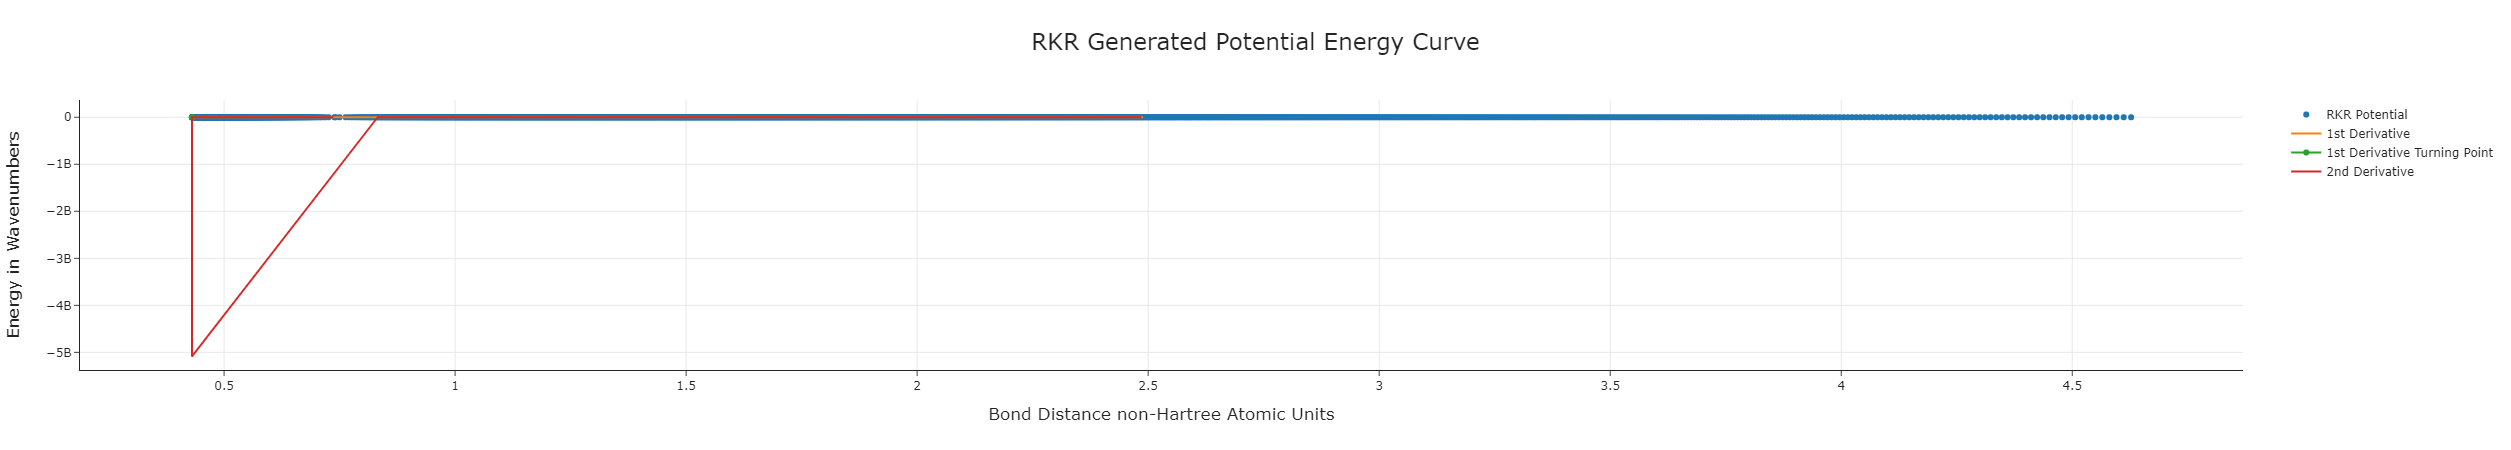

In [4]:
#Lists to hold data 
x = []
y = []
ddX = []
ddX2 = []
ddx = []
ddx2 = []
leftAsympCutOff = False

x.append(re)
y.append(0)

#Loop to generate all data to graph
print("Building RKR Potential")
for v in tqdm(np.arange(-.499, 17, .01)):
    
    energy = E(v, 0)
    xPoints = RKR(v)
    
    if(len(x) != 0):
        #Compute First Derivative
        ddX.append( (min(xPoints) + min(x[-2:])) / 2 )
        slope = (energy-y[-1]) / ( min(xPoints) - min(x[-2:]) )
        ddx.append( slope )
        
        if(len(ddx) > 1):
            #Compute 2nd Derivative
            ddX2.append( (ddX[-2] + ddX[-1]) / 2 )
            ddx2.append( (ddx[-1] - ddx[-2]) / (ddX[-1] - ddX[-2]) )
            
            #Determine if Cutoff should be used
            if(ddx2[-1] <= 0):
                leftAsympCutOff = True
                
    if(not leftAsympCutOff):
        x.extend( xPoints )
        y.extend( [energy] * 2 )
    else:
        x.append(max(xPoints))
        y.append(energy)
        
print("Graphing Potential")
#Prepare data for graphing
figure = {
    "data":[
        {
            "type":"scatter",
            "x":x,
            "y":y,
            "connectgaps":True,
            "mode":"markers",
            "name":"RKR Potential",
        }
    ],
    
    "layout":{
        "xaxis":{"title":"Bond Distance non-Hartree Atomic Units"},
        "yaxis":{"title":"Energy in Wavenumbers"},
        "title":{"text":"RKR Generated Potential Energy Curve"}
    }
}

figure["data"].append(
    {
        "type":"scatter",
        "x":ddX,
        "y":ddx,
        "name":"1st Derivative"
    }
)

figure["data"].append(
    {
        "type":"scatter",
        "x":[ddX[ddx.index(min(ddx))]] * 2,
        "y":[0, pow(10, 4) * 2],
        "name":"1st Derivative Turning Point"
    }
)

figure["data"].append(
    {
        "type":"scatter",
        "x":ddX2,
        "y":ddx2,
        "name":"2nd Derivative"
    }
)

iplot(figure)

In [5]:
#Test for the RKR Class
from rkr import rkr as rkrClass

rkr = rkrClass()

rkr.setDiatomicConstants(alphae, Be, we, wxe, wye, wze, ye)
rkr.setReducedMass(0.5)
rkr.setDelta(delta)

x, y = rkr.graphData()


figure = {
    
    "data":[
        {
            "type":"scatter",
            "x":x,
            "y":y,
            "connectgaps":True,
            "mode":"markers",
            "name":"RKR Potential",
        }
    ],
    
    "layout":{
        "xaxis":{"title":"Bond Distance non-Hartree Atomic Units"},
        "yaxis":{"title":"Energy in Wavenumbers"},
        "title":{"text":"RKR Generated Potential Energy Curve"}
    }
}

iplot(figure)

TypeError: __init__() missing 1 required positional argument: 'diatomicConstants'

In [ ]:
E(900)